In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


## Data Ingestion and Preparation

- Handles the data ingestion process for a machine learning pipeline.  
- Loads training data from a folder containing multiple CSV files and concatenates them into a single DataFrame for easier processing.  
- Splits the dataset into:
  - **Training set**: 80% of the data  
  - **Validation set**: 20% of the data  
- Loads test data from a separate folder, using only the first six CSV files.  
- Adds column headers to ensure consistent naming for features, such as:
  - Laser readings  
  - Robot position  
  - Goals  
  - Command velocities  
- Displays the shapes of the **training**, **validation**, and **test datasets** to confirm successful loading and preparation for subsequent steps.


In [17]:
print("Step 1: Data Ingestion - Loading datasets from folder...")
# Load Training Data from Entire Folder
train_folder_path = r'D:\UMD\MEng Robotics\Semester 3\Intro to Machine Learning\Final_Project\ENPM633_FInal_project_pycharm\Training\Open_Box_CSV_files'
train_data_list = []
for file_name in os.listdir(train_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(train_folder_path, file_name)
        train_data_list.append(pd.read_csv(file_path, header=None))
train_data = pd.concat(train_data_list, ignore_index=True)
train_data,val_data = train_test_split(train_data, train_size=0.8,test_size=0.2)
print(f"Loaded training data from {train_folder_path}, shape: {train_data.shape}")

# Load Test Data from First 6 Files
test_folder_path = r'D:\UMD\MEng Robotics\Semester 3\Intro to Machine Learning\Final_Project\ENPM633_FInal_project_pycharm\Testing'
test_data_list = []
for i, file_name in enumerate(os.listdir(test_folder_path)):
    if file_name.endswith('.csv') and i < 6:
        file_path = os.path.join(test_folder_path, file_name)
        test_data_list.append(pd.read_csv(file_path, header=None))
test_data = pd.concat(test_data_list, ignore_index=True)
print(f"Loaded testing data from {test_folder_path}, shape: {test_data.shape}")

# Add headers for columns
headers = [f"Laser_{i}" for i in range(1080)] + [
    "Final_goal_x", "Final_goal_y", "Final_goal_qk", "Final_goal_qr",
    "Local_goal_x", "Local_goal_y", "Local_goal_qk", "Local_goal_qr",
    "Robot_pos_x", "Robot_pos_y", "Robot_pos_qk", "Robot_pos_qr",
    "Cmd_vel_v", "Cmd_vel_w"
]
train_data.columns = headers
val_data.columns = headers
test_data.columns = headers
print(f"Training data shape after assigning headers: {train_data.shape}")
print(f"Validation data shape after assigning headers: {val_data.shape}")
print(f"Test data shape after assigning headers: {test_data.shape}")


Step 1: Data Ingestion - Loading datasets from folder...
Loaded training data from D:\UMD\MEng Robotics\Semester 3\Intro to Machine Learning\Final_Project\ENPM633_FInal_project_pycharm\Training\Open_Box_CSV_files, shape: (378384, 1094)
Loaded testing data from D:\UMD\MEng Robotics\Semester 3\Intro to Machine Learning\Final_Project\ENPM633_FInal_project_pycharm\Testing, shape: (88296, 1094)
Training data shape after assigning headers: (378384, 1094)
Validation data shape after assigning headers: (94597, 1094)
Test data shape after assigning headers: (88296, 1094)



The next cell implements a comprehensive process for data cleaning, feature creation, and preprocessing. Here's a brief summary of its key functionalities:

1. **Data Cleaning**: 
   - Removes duplicate rows and handles missing values, ensuring a clean and reliable dataset for analysis.

2. **Feature Engineering**: 
   - Adds geometric features like distances and angles to the final and local goals, enhancing the dataset's predictive power for robotics navigation tasks.

3. **Standardization and PCA**: 
   - Standardizes laser sensor data for consistency and applies Principal Component Analysis (PCA) to reduce dimensionality while retaining 99% of the variance, optimizing computational efficiency.
4. **Integration of Features**:
   - Combines engineered features and PCA components while removing raw laser data, preparing the dataset for machine learning models.



In [18]:
# Data Cleaning Function
def clean_data(data):
    data = data.drop_duplicates()
    data = data.dropna()
    return data

# Feature Engineering Function
def add_features(data):
    data = data.copy()
    data['distance_to_final_goal'] = np.sqrt((data['Final_goal_x'] - data['Robot_pos_x'])**2 +
                                             (data['Final_goal_y'] - data['Robot_pos_y'])**2)
    data['distance_to_local_goal'] = np.sqrt((data['Local_goal_x'] - data['Robot_pos_x'])**2 +
                                             (data['Local_goal_y'] - data['Robot_pos_y'])**2)
    data['angle_to_final_goal'] = np.arctan2(data['Final_goal_y'] - data['Robot_pos_y'],
                                             data['Final_goal_x'] - data['Robot_pos_x'])
    data['angle_to_local_goal'] = np.arctan2(data['Local_goal_y'] - data['Robot_pos_y'],
                                             data['Local_goal_x'] - data['Robot_pos_x'])
    return data

# Clean the datasets
train_data = clean_data(train_data)
val_data = clean_data(val_data)
test_data = clean_data(test_data)

# Add features to the datasets
train_data = add_features(train_data)
val_data = add_features(val_data)
test_data = add_features(test_data)

# Define Laser Columns
laser_columns = [f"Laser_{i}" for i in range(1080)]
engineered_features = [
    'distance_to_final_goal', 'distance_to_local_goal',
    'angle_to_final_goal', 'angle_to_local_goal'
]

# Standardize Laser Data using training set only
scaler = StandardScaler()
scaler.fit(train_data[laser_columns])

train_scaled_laser = scaler.transform(train_data[laser_columns])
val_scaled_laser = scaler.transform(val_data[laser_columns])
test_scaled_laser = scaler.transform(test_data[laser_columns])

# Apply PCA
pca = PCA(n_components=0.99)  # Retain 99% of variance
pca_train = pca.fit_transform(train_scaled_laser)
pca_val = pca.transform(val_scaled_laser)
pca_test = pca.transform(test_scaled_laser)

# Print the number of components the laser columns were reduced to
print(f"Number of PCA components retained: {pca_train.shape[1]}")

# Add PCA Components to the datasets
pca_columns = [f"PCA_{i+1}" for i in range(pca_train.shape[1])]

train_data = pd.concat([train_data, pd.DataFrame(pca_train, columns=pca_columns, index=train_data.index)], axis=1)
val_data = pd.concat([val_data, pd.DataFrame(pca_val, columns=pca_columns, index=val_data.index)], axis=1)
test_data = pd.concat([test_data, pd.DataFrame(pca_test, columns=pca_columns, index=test_data.index)], axis=1)

# Drop Original Laser Data
train_data.drop(columns=laser_columns, inplace=True)
val_data.drop(columns=laser_columns, inplace=True)
test_data.drop(columns=laser_columns, inplace=True)

# Prepare Features and Targets
X_train = train_data[pca_columns + engineered_features]
y_train = train_data["Cmd_vel_v"]

X_val = val_data[pca_columns + engineered_features]
y_val = val_data["Cmd_vel_v"]

X_test = test_data[pca_columns + engineered_features]
y_test = test_data["Cmd_vel_v"]


Number of PCA components retained: 119


## Model Training and Evaluation

- **Model Definition**:  
  A variety of regression models are defined for training and evaluation:
  - Linear Regression
  - Ridge Regression (with alpha=1.0)
  - Lasso Regression (with alpha=0.01)
  - Decision Tree Regressor (max_depth=10, min_samples_split=10)
  - XGBoost Regressor (50 estimators, max_depth=10, learning_rate=0.1)
  - LightGBM Regressor (50 estimators, max_depth=10, learning_rate=0.1)

- **Training Process**:  
  - Each model is trained on the training dataset (`X_train`, `y_train`).  
  - Predictions are generated for both the training and test datasets.  
  - The performance of each model is evaluated using Root Mean Squared Error (RMSE) for:
    - Training predictions
    - Test predictions  

- **Output**:  
  - Displays the RMSE for each model on both the training and test datasets, providing insight into their performance.


In [19]:
#Model Training and Evaluation
# Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=10),
    "XGBoost": XGBRegressor(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=42, eval_metric='rmse'),
    "LightGBM": LGBMRegressor(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=42)
    
}

# Train Models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_predictions = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    print(f"{name} - Training RMSE: {train_rmse:.4f}")
    print(f"{name} - Test RMSE: {test_rmse:.4f}")


Training Linear Regression...
Linear Regression - Training RMSE: 0.2226
Linear Regression - Test RMSE: 0.2341

Training Ridge Regression...
Ridge Regression - Training RMSE: 0.2226
Ridge Regression - Test RMSE: 0.2341

Training Lasso Regression...
Lasso Regression - Training RMSE: 0.2238
Lasso Regression - Test RMSE: 0.2345

Training Decision Tree...
Decision Tree - Training RMSE: 0.1233
Decision Tree - Test RMSE: 0.1409

Training XGBoost...
XGBoost - Training RMSE: 0.0836
XGBoost - Test RMSE: 0.1183

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31365
[LightGBM] [Info] Number of data points in the train set: 363661, number of used features: 123
[LightGBM] [Info] Start training from score 0.483413
LightGBM - Training RMSE: 0.1217
LightGBM - Test RMSE: 0.1276


## Hyperparameter Tuning

- **Hyperparameter Grid Definition**:  
  - Specifies a range of values for tuning model hyperparameters using randomized search.
  - Example grids include:
    - **Ridge Regression**: `alpha` (0.001 to 10)
    - **Lasso Regression**: `alpha` (0.001 to 1)
    - **Decision Tree**: `max_depth` (5 to 20), `min_samples_split` (2 to 20)
    - **XGBoost**: `n_estimators` (50 to 100), `max_depth` (3 to 15), `learning_rate` (0.01 to 0.3)
    - **LightGBM**: Similar to XGBoost

- **Custom Scorer**:  
  - Implements Root Mean Squared Error (RMSE) as a custom scoring metric for model evaluation.

- **Hyperparameter Tuning Process**:  
  - Uses `RandomizedSearchCV` to search for the best hyperparameters for each model.
  - Evaluates models using 3-fold cross-validation with negative mean squared error as the scoring metric.

- **Results**:  
  - Prints the best hyperparameters for each model, if applicable.  
  - Displays RMSE scores for each fold during cross-validation and calculates the average RMSE.

- **Output**:  
  - Saves the best-tuned model for each algorithm for further evaluation or deployment.


In [20]:
# Define hyperparameter grids
param_grids = {
    "Decision Tree": {
        "max_depth": randint(5, 20),
        "min_samples_split": randint(2, 20),
    },
    "XGBoost": {
        "n_estimators": randint(50, 100),
        "max_depth": randint(3, 15),
        "learning_rate": uniform(0.01, 0.3),
    },
    "LightGBM": {
        "n_estimators": randint(50, 100),
        "max_depth": randint(3, 15),
        "learning_rate": uniform(0.01, 0.3),
    }
}

# Custom RMSE scorer
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform Hyperparameter Tuning and Save Best Models
best_models = []
for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")
    if name in param_grids and param_grids[name]:
        search = RandomizedSearchCV(
            model,
            param_distributions=param_grids[name],
            n_iter=10,
            scoring='neg_mean_squared_error',
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        print(f"Best parameters for {name}: {search.best_params_}")

        # Calculate RMSE for each fold in cross-validation
        fold_scores = cross_val_score(
            best_model,
            X_train,
            y_train,
            scoring=make_scorer(rmse_scorer, greater_is_better=False),
            cv=3
        )
        rmse_scores = -fold_scores  # Negated because sklearn uses negative scores for minimization
        print(f"RMSE for each fold for {name}: {rmse_scores}")
        print(f"Average RMSE for {name}: {np.mean(rmse_scores):.4f}")
    else:
        best_model = model
        print(f"{name} has no hyperparameters to tune. Using the default model.")

    best_models.append((name, best_model))



Tuning hyperparameters for Linear Regression...
Linear Regression has no hyperparameters to tune. Using the default model.

Tuning hyperparameters for Ridge Regression...
Ridge Regression has no hyperparameters to tune. Using the default model.

Tuning hyperparameters for Lasso Regression...
Lasso Regression has no hyperparameters to tune. Using the default model.

Tuning hyperparameters for Decision Tree...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Decision Tree: {'max_depth': 12, 'min_samples_split': 13}
RMSE for each fold for Decision Tree: [0.13154651 0.13015098 0.13011198]
Average RMSE for Decision Tree: 0.1306

Tuning hyperparameters for XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for XGBoost: {'learning_rate': 0.12236203565420874, 'max_depth': 13, 'n_estimators': 57}
RMSE for each fold for XGBoost: [0.09948126 0.10066121 0.09978643]
Average RMSE for XGBoost: 0.1000

Tuning hyperparameters for Lig

## Retraining and Evaluation of LightGBM and XGBoost

- **Best Hyperparameters**:  
  - LightGBM:
    - `learning_rate`: 0.1896
    - `max_depth`: 9
    - `n_estimators`: 68
  - XGBoost:
    - `learning_rate`: 0.1224
    - `max_depth`: 13
    - `n_estimators`: 57

- **Model Instantiation**:  
  - Creates instances of LightGBM and XGBoost models with the best hyperparameters obtained from the tuning step.

- **Training and Evaluation Process**:  
  - **LightGBM**:
    - Trains the model using the training dataset (`X_train`, `y_train`).
    - Evaluates performance by predicting on both training and test datasets.
    - Calculates and displays RMSE for:
      - Training predictions
      - Test predictions
  - **XGBoost**:
    - Follows the same process as LightGBM for training and evaluation.

- **Output**:  
  - Reports the RMSE for both LightGBM and XGBoost models, providing insights into their training and test performance.


In [21]:
# Best hyperparameters for LightGBM and XGBoost (from the tuning step)
lightgbm_params = {'learning_rate': 0.189597545259111, 'max_depth': 9, 'n_estimators': 68}
xgboost_params = {'learning_rate': 0.12236203565420874, 'max_depth': 13, 'n_estimators': 57}

# Instantiate models with the best hyperparameters
lightgbm = LGBMRegressor(**lightgbm_params)
xgboost = XGBRegressor(**xgboost_params)

# Retrain LightGBM
print("\nTraining and Validating LightGBM...")
lightgbm.fit(X_train, y_train)

# Evaluate LightGBM
lightgbm_train_predictions = lightgbm.predict(X_train)
lightgbm_val_predictions = lightgbm.predict(X_val)

lightgbm_train_rmse = np.sqrt(mean_squared_error(y_train, lightgbm_train_predictions))
lightgbm_val_rmse = np.sqrt(mean_squared_error(y_val, lightgbm_val_predictions))

print(f"LightGBM - Training RMSE: {lightgbm_train_rmse:.4f}")
print(f"LightGBM - Validation RMSE: {lightgbm_val_rmse:.4f}")

# Retrain XGBoost
print("\nTraining and Validating XGBoost...")
xgboost.fit(X_train, y_train)

# Evaluate XGBoost
xgboost_train_predictions = xgboost.predict(X_train)
xgboost_val_predictions = xgboost.predict(X_val)

xgboost_train_rmse = np.sqrt(mean_squared_error(y_train, xgboost_train_predictions))
xgboost_val_rmse = np.sqrt(mean_squared_error(y_val, xgboost_val_predictions))

print(f"XGBoost - Training RMSE: {xgboost_train_rmse:.4f}")
print(f"XGBoost - Validation RMSE: {xgboost_val_rmse:.4f}")



Training and Validating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31365
[LightGBM] [Info] Number of data points in the train set: 363661, number of used features: 123
[LightGBM] [Info] Start training from score 0.483413
LightGBM - Training RMSE: 0.1115
LightGBM - Validation RMSE: 0.1151

Training and Validating XGBoost...
XGBoost - Training RMSE: 0.0434
XGBoost - Validation RMSE: 0.0918


## Learning Curves for LightGBM (Finalized Model)

- **Best Hyperparameters**:  
  - `learning_rate`: 0.1896  
  - `max_depth`: 9  
  - `n_estimators`: 68  

- **Model Initialization**:  
  - The LightGBM model is initialized using the best hyperparameters obtained from the tuning step.

- **Learning Curve Generation**:  
  - The training process is conducted on subsets of the training data, ranging from 10% to 100% of the dataset.  
  - For each subset size:
    - The model is trained using the sampled data.  
    - Root Mean Squared Error (RMSE) is calculated for:
      - The training subset (Training RMSE)  
      - The entire validation dataset (Validation RMSE)

- **Visualization**:  
  - A learning curve is plotted to show the relationship between the training set size and model performance:
    - **X-axis**: Training set size as a percentage.  
    - **Y-axis**: RMSE values for both training and validation datasets.  
  - The plot highlights how the model's error decreases as the training size increases, providing insights into overfitting or underfitting behavior.

- **Output**:  
  - A grid-enabled plot showing Training RMSE and Validation RMSE as a function


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31365
[LightGBM] [Info] Number of data points in the train set: 36366, number of used features: 123
[LightGBM] [Info] Start training from score 0.480167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31365
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 123
[LightGBM] [Info] Start training from score 0.481261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31365
[LightGBM] [Info] Number of data points in the train set: 109098, number of used features: 123
[LightGBM] [Info] St

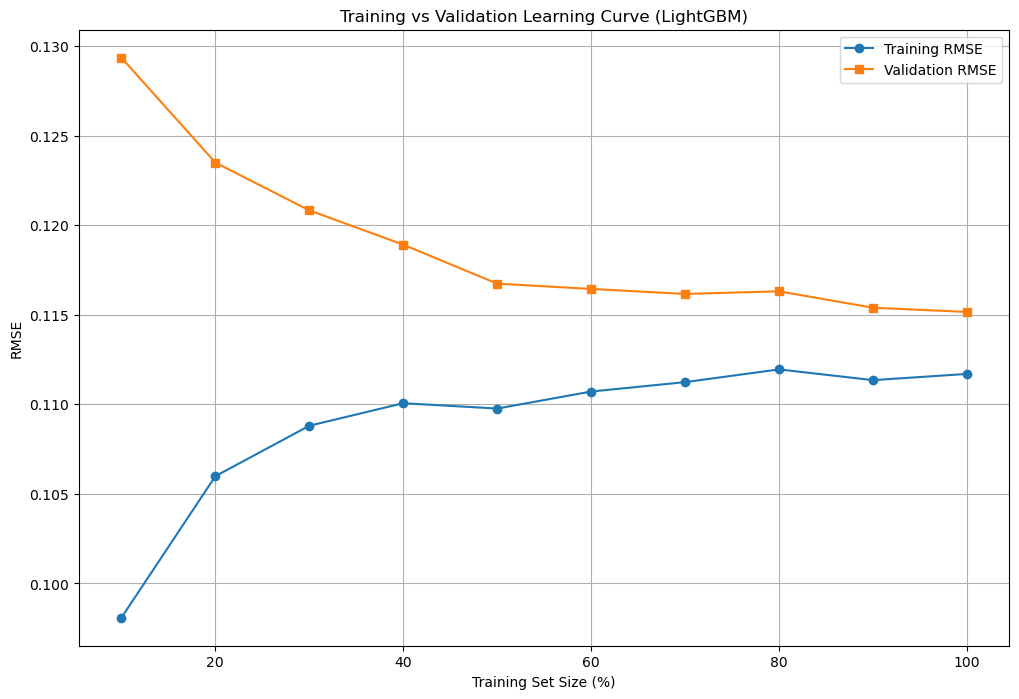

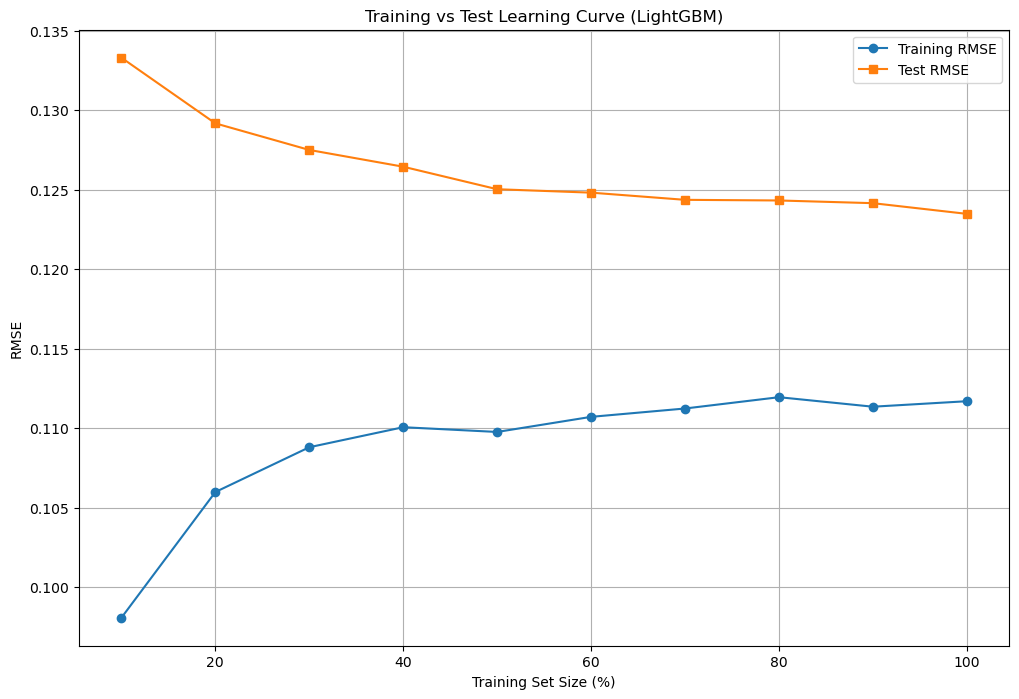

In [25]:
# Best hyperparameters for LightGBM from tuning
lightgbm_params = {'learning_rate': 0.189597545259111, 'max_depth': 9, 'n_estimators': 68}

# Initialize the LightGBM model with best hyperparameters
lightgbm = LGBMRegressor(**lightgbm_params, random_state=42)

# Generate learning curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
train_rmse = []
val_rmse = []
test_rmse = []

for train_size in train_sizes:
    # Sample the training data based on train_size
    X_train_subset = X_train[:int(train_size * len(X_train))]
    y_train_subset = y_train[:int(train_size * len(y_train))]
    
    # Fit the model on the subset
    lightgbm.fit(X_train_subset, y_train_subset)
    
    # Predict and calculate RMSE for training data
    train_predictions = lightgbm.predict(X_train_subset)
    train_rmse.append(np.sqrt(mean_squared_error(y_train_subset, train_predictions)))
    
    # Predict and calculate RMSE for validation data
    val_predictions = lightgbm.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, val_predictions)))
    
    # Predict and calculate RMSE for test data
    test_predictions = lightgbm.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_predictions)))


# Plot the learning curves
plt.figure(figsize=(12, 8))

# Training vs Validation Learning Curve
plt.plot(train_sizes * 100, train_rmse, label="Training RMSE", marker="o")
plt.plot(train_sizes * 100, val_rmse, label="Validation RMSE", marker="s")
plt.title("Training vs Validation Learning Curve (LightGBM)")
plt.xlabel("Training Set Size (%)")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()

# Training vs Test Learning Curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes * 100, train_rmse, label="Training RMSE", marker="o")
plt.plot(train_sizes * 100, test_rmse, label="Test RMSE", marker="s")
plt.title("Training vs Test Learning Curve (LightGBM)")
plt.xlabel("Training Set Size (%)")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()


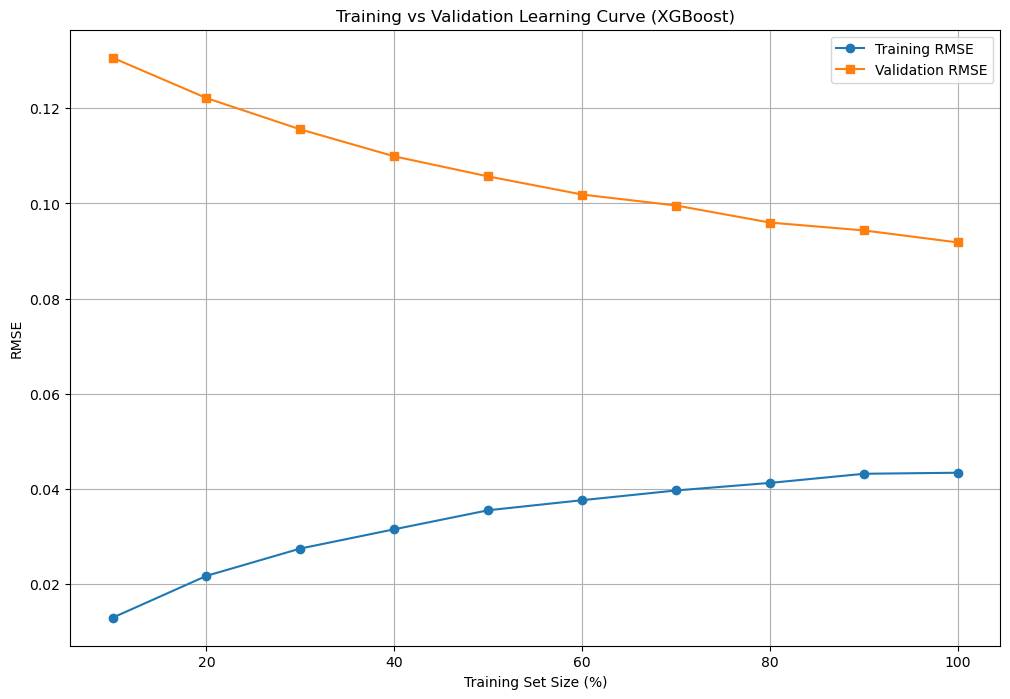

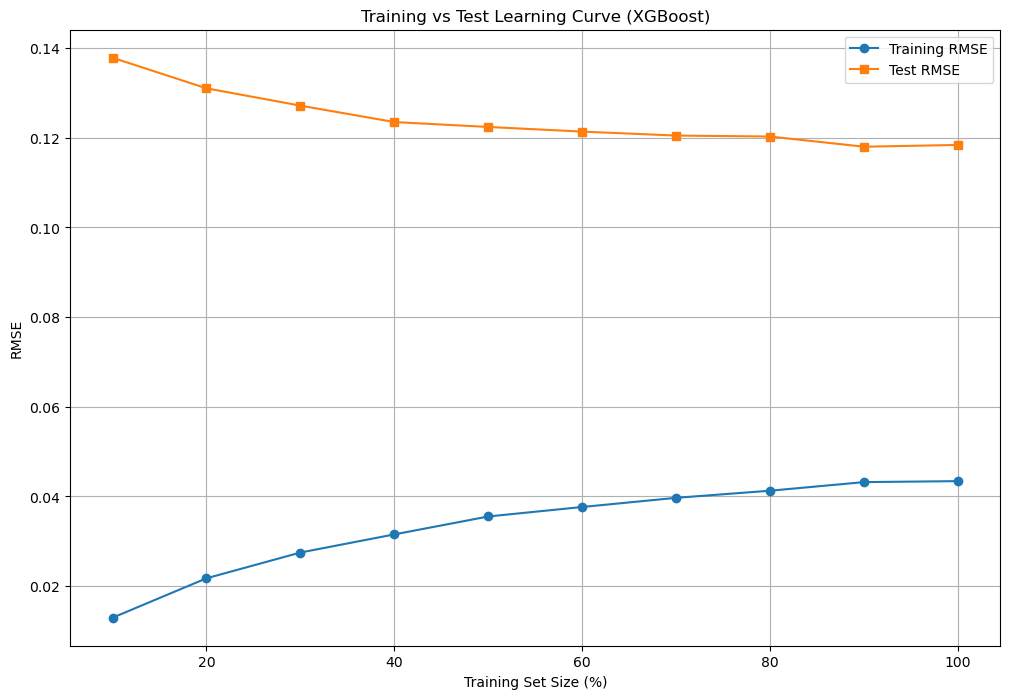

In [26]:
# Best hyperparameters for XGBoost from tuning
xgboost_params = {'learning_rate': 0.12236203565420874, 'max_depth': 13, 'n_estimators': 57}

# Initialize the XGBoost model with best hyperparameters
xgboost = XGBRegressor(**xgboost_params, random_state=42)

# Generate learning curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Training sizes from 10% to 100%
train_rmse = []
val_rmse = []
test_rmse = []

for train_size in train_sizes:
    # Sample the training data based on train_size
    X_train_subset = X_train[:int(train_size * len(X_train))]
    y_train_subset = y_train[:int(train_size * len(y_train))]
    
    # Fit the model on the subset
    xgboost.fit(X_train_subset, y_train_subset)
    
    # Predict and calculate RMSE for training data
    train_predictions = xgboost.predict(X_train_subset)
    train_rmse.append(np.sqrt(mean_squared_error(y_train_subset, train_predictions)))
    
    # Predict and calculate RMSE for validation data
    val_predictions = xgboost.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, val_predictions)))
    
    # Predict and calculate RMSE for test data
    test_predictions = xgboost.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_predictions)))


# Plot the learning curves
plt.figure(figsize=(12, 8))

# Training vs Validation Learning Curve
plt.plot(train_sizes * 100, train_rmse, label="Training RMSE", marker="o")
plt.plot(train_sizes * 100, val_rmse, label="Validation RMSE", marker="s")
plt.title("Training vs Validation Learning Curve (XGBoost)")
plt.xlabel("Training Set Size (%)")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()

# Training vs Test Learning Curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes * 100, train_rmse, label="Training RMSE", marker="o")
plt.plot(train_sizes * 100, test_rmse, label="Test RMSE", marker="s")
plt.title("Training vs Test Learning Curve (XGBoost)")
plt.xlabel("Training Set Size (%)")
plt.ylabel("RMSE")
plt.legend()
plt.grid()
plt.show()
